# Transformation to C Code (Simple)

## Imports

In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np

from library.zoomy_core.fvm.solver_jax import Settings
from library.zoomy_core.model.models.shallow_water import ShallowWaterEquations

import library.zoomy_core.model.initial_conditions as IC
import library.zoomy_core.model.boundary_conditions as BC
from library.zoomy_core.misc.misc import Zstruct
import library.zoomy_core.transformation.to_c as trafo
import library.zoomy_core.mesh.mesh as petscMesh


## Model definition

In [2]:
bcs = BC.BoundaryConditions(
    [
        BC.Wall(tag="wall"),
        BC.Wall(tag="inflow"),
        BC.Wall(tag="outflow"),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = ShallowWaterEquations(
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
)

# the mesh is necessary to connect the boundary conditions to the mesh tags
main_dir = os.getenv("ZOOMY_DIR")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_quad_2d/mesh.msh")
)
model.initialize_boundary_conditions(mesh)

## Sympy Model

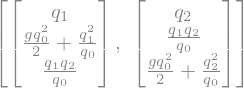

In [3]:
model.flux()

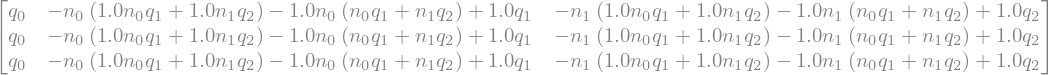

In [4]:
model.print_boundary_conditions()

## Code transformation

In [5]:
settings = Settings(name="ShallowWater", output=Zstruct(directory="outputs/trafo", filename="swe.h5"))
trafo.write_code(model, settings)

2025-10-13 16:22:40.258 | WARNING  | library.core.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


## Check the output

In [7]:
main_dir = os.getenv("ZOOMY_DIR")
path = os.path.join(main_dir, os.path.join(settings.output.directory, '.c_interface/Model.H'))
with open(path, "r") as f:
    print(f.read())


#pragma once

namespace Model
{
constexpr int n_dof_q    = 3;
constexpr int n_dof_qaux = 2;
constexpr int dimension  = 2;
static const int n_boundary_tags = 3;
static const char* map_boundary_tag_to_function_index[] = { "wall", "inflow", "outflow" };

inline void flux_x(
    const double* Q,
    const double* Qaux,
    double* res
    )
{
    double t0 = (1.0 / std::pow(Q[0], 1));
        res[0] = Q[1];
        res[1] = (1.0/2.0)*9.81*std::pow(Q[0], 2) + std::pow(Q[1], 2)*t0;
        res[2] = Q[1]*Q[2]*t0;
}
        

inline void flux_y(
    const double* Q,
    const double* Qaux,
    double* res
    )
{
    double t0 = (1.0 / std::pow(Q[0], 1));
        res[0] = Q[2];
        res[1] = Q[1]*Q[2]*t0;
        res[2] = (1.0/2.0)*9.81*std::pow(Q[0], 2) + std::pow(Q[2], 2)*t0;
}
        

inline void flux_jacobian_x(
    const double* Q,
    const double* Qaux,
    double* res
    )
{
    double t0 = (1.0 / std::pow(Q[0], 2));
        double t1 = (1.0 / std::pow(Q[0], 1));
        double t